# Проблема оптимизации SMV

SVM классификатор максимизирует двойственную функцию Лагранжа, заданную формулой:

$$L_d = -\frac{1}{2} \sum_i \sum_k \alpha_i \alpha_k t_i t_k (x_i)^T (x_k) + \sum_i \alpha_i$$
, где:
$$\begin{eqnarray}
0 \leq \alpha_i \leq C, & \forall i\\
\sum_i \alpha_i t_i = 0& \\
\end{eqnarray}$$

Необходимо найти множитель $\alpha$, связанный к каждой точкой обучения

# Реализация SVM

Для вычислений мы воспользуемся SciPy

In [3]:
import numpy as np    
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For generating dataset
import sklearn.datasets as dt

Нам необходимо определить собственный порог нуля для нахождения альфа-каналов, численно близких к нулю

In [4]:
ZERO = 1e-7

Мы определим простой набор данных, метки и простую функцию для построения графика. Опционально, если передана строка альфа-каналов, функция пометит опорные векторы соответствующими альфа-значениями (опорные векторы - это точки, для которых $\alpha>0$)

In [5]:
dat = np.array([[0, 3], [-1, 0], [1, 2], [2, 1], [3,3], [0, 0], [-1, -1], [-3, 1], [3, 1]])
labels = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1])

In [6]:
def plot_x(x, t, alpha=[], C=0):
    sns.scatterplot(x=dat[:,0], y=dat[:, 1], style=labels,
    hue=labels, markers=['s', 'P'],
    palette=['magenta', 'green'])
    if len(alpha) > 0:
        alpha_str = np.char.mod('%.1f', np.round(alpha, 1))
        ind_sv = np.where(alpha > ZERO)[0]
        for i in ind_sv:   
            plt.gca().text(dat[i,0], dat[i, 1]-.25, alpha_str[i] )

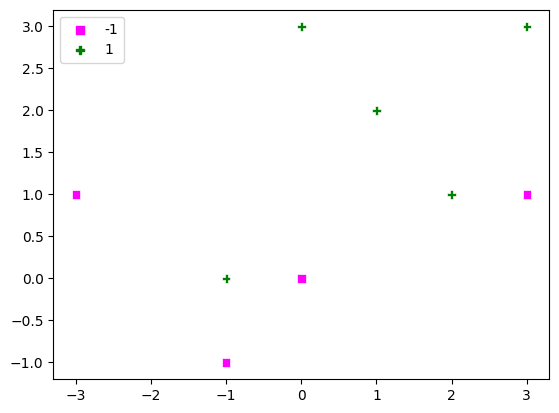

In [7]:
plot_x(dat, labels)

## Функция minimize()

Функция minimize() в scipy.optimize требует следующие аргументы:
- Целевая функция для минимизации (двойственная функция Лагранжа)
- Начальные значения переменных (множители Лагранжа $\alpha$, в нашем случае мы выберем их случайно)
- Метод оптимизации (мы будем использовать trust-constr)
- Линейные ограничения на альфа
- Границы альфа

## Определение целевой функции

Целевая функция, определённая выше, должна быть максимизирована, потому перед использованием функции минимизации необходимо умножить нё на (-1). Первым параметром целевой функции является переменная, по которой происходит оптимизация. Так же нам нужны тренировачные данные.

In [8]:
# Objective function
def lagrange_dual(alpha, x, t):
    result = 0
    ind_sv = np.where(alpha > ZERO)[0]
    for i in ind_sv:
        for k in ind_sv:
            result = result + alpha[i]*alpha[k]*t[i]*t[k]*np.dot(x[i, :], x[k, :]) 
    result = 0.5*result - sum(alpha)     
    return result

## Определение линейных ограничений

Линейное ограничение для альфа определяется, как:

$$\sum_i \alpha_i t_i = 0$$

Можно переписать это в следующем виде:

$$\alpha_0 t_0 + \alpha_1 t_1 + \ldots \alpha_m t_m = 0$$

Метод LinearConstraint() требует записи в матричной форме.

$$\begin{equation}
0 =
\begin{bmatrix}
t_0 & t_1 & \ldots t_m
\end{bmatrix}
\begin{bmatrix}
\alpha_0\\ \alpha_1 \\ \vdots \\ \alpha_m
\end{bmatrix}
= 0
\end{equation}$$

Первая матрица является первым параметром LinearConstraint(). Левая и правая границы являются вторым и третьим аргументом.

In [9]:
linear_constraint = LinearConstraint(labels, [0], [0])
print(linear_constraint)

## Определенин границ

Границы альфы определяются с помощью метода Bounds(). Все альфа-каналы должны лежать между $0$ и $C$. На примере для $C=10$:

In [20]:
bounds_alpha = Bounds(np.zeros(dat.shape[0]), np.full(dat.shape[0], 10))
bounds_alpha

Bounds(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([10, 10, 10, 10, 10, 10, 10, 10, 10]))

## Определение функции для поиска альф

Напишем функцию поиска оптимальных значений альфа при заданных параметрах x, t и c

In [11]:
def optimize_alpha(x, t, C):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(t, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (x, t), method='trust-constr', 
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha

## Определение гиперплоскости

Выражение для гиперплоскасти задаётся следующим образом:

$$w^T x + w_0 = 0$$

Для гиперплоскости нам нужен весовой вектор $w$ и постоянная $w_0$. Весовой вектор определяется как:

$$w = \sum_i \alpha_i t_i x_i$$

Если точек обучения слишком много, лучше использовать только опорные векторы $\alpha>0$ для вычисления вектора весов

W0 мы вычислим из каждого опорного вектора $s$, для которого $\alpha_s < C$ взяв среднее значение. Для одного опорного вектора $x_s$:

$$w_0 = t_s – w^T x_s$$

Альфа опорного вектора не может быть численно точно равна $C$. Следовательно мы можем вычесть заданную ранее константу из $С$, чтобы нвйти все опорные векторы $\alpha_s < C$

In [12]:
def get_w(alpha, t, x):
    m = len(x)
    # Get all support vectors
    w = np.zeros(x.shape[1])
    for i in range(m):
        w = w + alpha[i]*t[i]*x[i, :]        
    return w
 
def get_w0(alpha, t, x, w, C):
    C_numeric = C-ZERO
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > ZERO)&(alpha < C_numeric))[0]
    w0 = 0.0
    for s in ind_sv:
        w0 = w0 + t[s] - np.dot(x[s, :], w)
    # Take the average    
    w0 = w0 / len(ind_sv)
    return w0

## Классификация контрольных точек

Чтобы классифицировать контрольную точку $x_{test}$ используем функцию sign для $y(x_{test})$:

$$\text{label}_{x_{test}} = \text{sign}(y(x_{test})) = \text{sign}(w^T x_{test} + w_0)$$

Напишем соответсвующую функцию, которая принимает в качестве аргумента массив контрольных точек с $w$, $w_0$ и пклассифицирует точки, а так же вторую функцию расчёта коэффициента ошибочной классификации

In [13]:
def classify_points(x_test, w, w0):
    # get y(x_test)
    predicted_labels = np.sum(x_test*w, axis=1) + w0
    predicted_labels = np.sign(predicted_labels)
    # Assign a label arbitrarily a +1 if it is zero
    predicted_labels[predicted_labels==0] = 1
    return predicted_labels
 
def misclassification_rate(labels, predictions):
    total = len(labels)
    errors = sum(labels != predictions)
    return errors/total*100

## Построение границы и гиперплоскости

Так же определим функции для построения гиперплоскости и границы

In [15]:
def plot_hyperplane(w, w0):
    x_coord = np.array(plt.gca().get_xlim())
    y_coord = -w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, y_coord, color='red')

def plot_margin(w, w0):
    x_coord = np.array(plt.gca().get_xlim())
    ypos_coord = 1/w[1] - w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, ypos_coord, '--', color='green') 
    yneg_coord = -1/w[1] - w0/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, yneg_coord, '--', color='magenta')

## SVM

Визуализируем данные. Задаём случайные значения для альфа, определяем С и находим лучшие значения альфа в этой функции. Так же строим гиперплоскость, границу и точки данных. Опорные векторы будут отмечены соответствующим значением альфа. Заголовком графика будет процент ошибок и количество опорных векторов.

In [16]:
def display_SVM_result(x, t, C):
    # Get the alphas
    alpha = optimize_alpha(x, t, C)   
    # Get the weights
    w = get_w(alpha, t, x)
    w0 = get_w0(alpha, t, x, w, C)
    plot_x(x, t, alpha, C)
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plot_hyperplane(w, w0)
    plot_margin(w, w0)
    plt.xlim(xlim)
    plt.ylim(ylim)
    # Get the misclassification error and display it as title
    predictions = classify_points(x, w, w0)
    err = misclassification_rate(t, predictions)
    title = 'C = ' + str(C) + ',  Errors: ' + '{:.1f}'.format(err) + '%'
    title = title + ',  total SV = ' + str(len(alpha[alpha > ZERO]))
    plt.title(title)

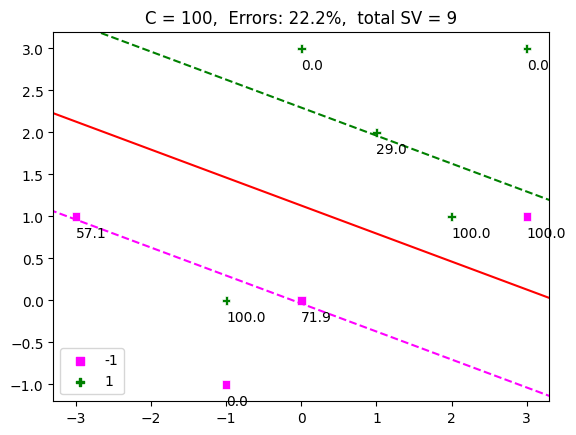

In [17]:
display_SVM_result(dat, labels, 100)    
plt.show()

## Влияние C

Если изменить значение $C$ на $\infty$ мягкая граница превратится в жесткую, не допускающую ошибок. Задача, которая определена выше, в данном случае неразрешима. Мы создадим искусственный набор точек и посмотрим влияние $C$ на классификацию. Для наглядности мы будем использовать простой набор данных, в котором можно разделить положительные и отрицательные примеры.

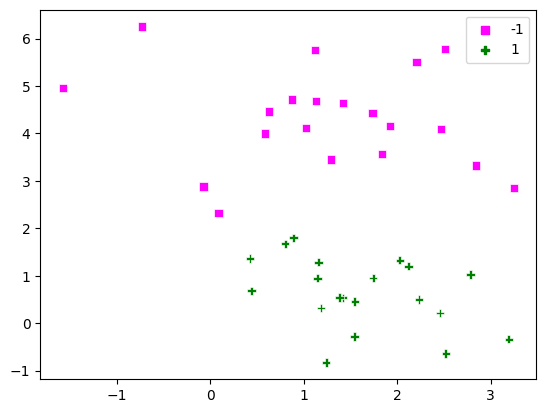

In [21]:
dat, labels = dt.make_blobs(n_samples=[20,20],
                           cluster_std=1,
                           random_state=0)
labels[labels==0] = -1
plot_x(dat, labels)

Определим несколько значений $C$ и запустим код

C:\Users\metar\Documents\GitHub\ISIT_M1\SVM_from_scratch\venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


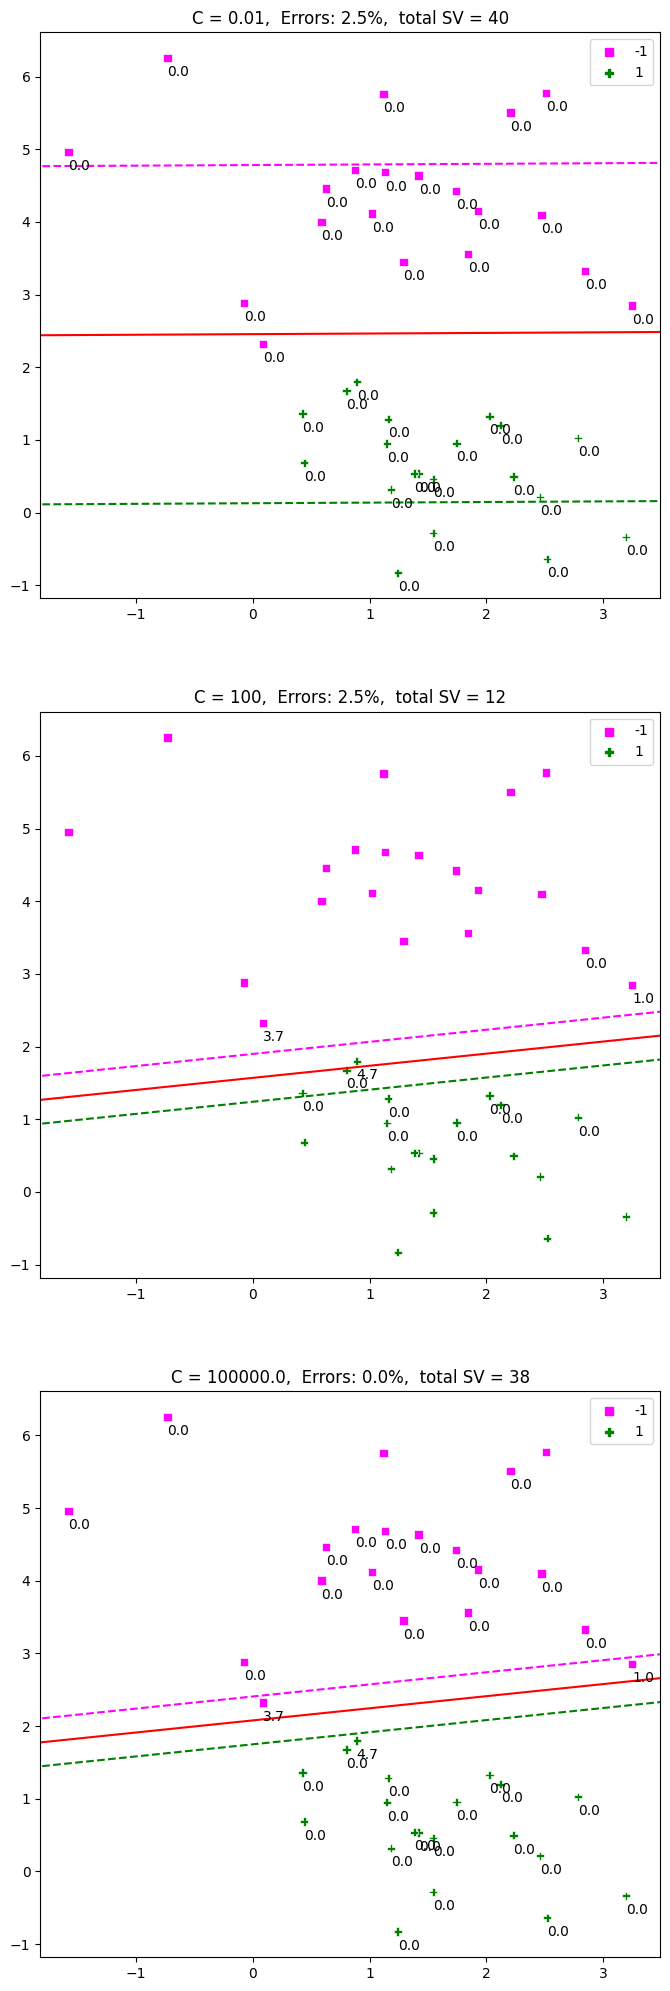

In [22]:
fig = plt.figure(figsize=(8,25))

i=0
C_array = [1e-2, 100, 1e5]

for C in C_array:
    fig.add_subplot(311+i)    
    display_SVM_result(dat, labels, C)  
    i = i + 1

Из результата отлично видно, что увеличение $C$ уменьшает площадь границы. Высоие значения $C$ добавляет более строгое обнаружение ошибок. Меньшее значение допускает более широкий запас и больше ошибок неправильной классификации. Следовательно, $C$ определяет компромисс между максимизацией границы и ошибками классификации